<a href="https://colab.research.google.com/github/zubayr1/NLP_Project_2021/blob/main/Task1_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Word Embeddings (10 points)

This notebook will guide you through all steps necessary to train a word2vec model (Detailed description in the PDF).

## Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages)

In [ ]:
# Imports
import pandas as pd
from google.colab import files
import io
import string
from numpy import random
import numpy as np

import time
import gc

import matplotlib.pyplot as plt

from google.colab import drive

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F

# 1.1 Get the data (0.5 points)

The Hindi portion HASOC corpus from [github.io](https://hasocfire.github.io/hasoc/2019/dataset.html) is already available in the repo, at data/hindi_hatespeech.tsv . Load it into a data structure of your choice. Then, split off a small part of the corpus as a development set (~100 data points).

If you are using Colab the first two lines will let you upload folders or files from your local file system.

In [ ]:
#TODO: implement!

uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['hindi_hatespeech.tsv']),  sep='\t')

#when running with a small development set
# df = df[:100]

#when running with full dataset
# data = df


Saving hindi_hatespeech.tsv to hindi_hatespeech.tsv


## 1.2 Data preparation (0.5 + 0.5 points)

* Prepare the data by removing everything that does not contain information. 
User names (starting with '@') and punctuation symbols clearly do not convey information, but we also want to get rid of so-called [stopwords](https://en.wikipedia.org/wiki/Stop_word), i. e. words that have little to no semantic content (and, but, yes, the...). Hindi stopwords can be found [here](https://github.com/stopwords-iso/stopwords-hi/blob/master/stopwords-hi.txt) Then, standardize the spelling by lowercasing all words.
Do this for the development section of the corpus for now.

* What about hashtags (starting with '#') and emojis? Should they be removed too? Justify your answer in the report, and explain how you accounted for this in your implementation.

In [ ]:
def data_preperation(data):
  #TODO: implement!

  #remove User names

  data.loc[:, 'text'] =  data.loc[:, 'text'].str.replace('(@\w+.*?)',"")



  #remove Punctuations

  data.loc[:, 'text'] = data.loc[:,'text'].str.replace('[{}]'.format(string.punctuation), "")
  data.loc[:, 'text'] = data.loc[:,'text'].str.replace(r'\+', "") 
  data.loc[:, 'text'] = data.loc[:,'text'].str.replace('।', "") 
  data.loc[:, 'text'] = data.loc[:,'text'].str.replace('…', "")


  #remove Stopwords
  !rm -rf /content/stopwords-hi

  !git clone https://github.com/stopwords-iso/stopwords-hi


  f=open("/content/stopwords-hi/stopwords-hi.txt", "r")

  if f.mode == 'r':
    contents =f.read()

  newcontent = contents.split()



  data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (newcontent)]))

  

  #lowercasing the words

  data['text'] = data['text'].str.lower()


  return data

data = data_preperation(df)

Cloning into 'stopwords-hi'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.


## 1.3 Build the vocabulary (0.5 + 0.5 points)

The input to the first layer of word2vec is an one-hot encoding of the current word. The output of the model is then compared to a numeric class label of the words within the size of the skip-gram window. Now

* Compile a list of all words in the development section of your corpus and save it in a variable ```V```.

In [ ]:
def building_vocabulary(data):
  #TODO: implement!
  WORDSINLIST =[]
  for i in list(data['text'].str.split()):
    for j in i:
      WORDSINLIST.append(j)

  # WORDSINLIST = df['text'].values.tolist()

  # print(WORDSINLIST)
  tempv = set(WORDSINLIST)

  V = pd.DataFrame({'Values': data} for data in tempv)
  


  #WORDLIST :: List of all words 

  #V :: Vocabulary -> unique set of words from WORDLIST

 
  return WORDSINLIST, V

# WORDSINLIST, V = building_vocabulary(data)



* Then, write a function ```word_to_one_hot``` that returns a one-hot encoding of an arbitrary word in the vocabulary. The size of the one-hot encoding should be ```len(v)```.

In [ ]:
#TODO: implement!

def word_to_one_hot(word):
  lis=[]
  for i in V['Values']:
    if i.strip() in word.strip() and word.strip() in i.strip():
      lis.append(1)
    else:
      lis.append(0)
  return lis

## 1.4 Subsampling (0.5 points)

The probability to keep a word in a context is given by:

$P_{keep}(w_i) = \Big(\sqrt{\frac{z(w_i)}{0.001}}+1\Big) \cdot \frac{0.001}{z(w_i)}$

Where $z(w_i)$ is the relative frequency of the word $w_i$ in the corpus. Now,
* Calculate word frequencies
* Define a function ```sampling_prob``` that takes a word (string) as input and returns the probabiliy to **keep** the word in a context.

In [ ]:
#TODO: implement!
def sampling_prob(word):
  COUNT = 0
  COUNT = WORDSINLIST.count(word)
  
  
  Z = COUNT/len(WORDSINLIST)
  if Z==0:
    return 0
  
  return ((((Z/0.001)**.5) + 1 )* (0.001/ Z))

# 1.5 Skip-Grams (1 point)

Now that you have the vocabulary and one-hot encodings at hand, you can start to do the actual work. The skip gram model requires training data of the shape ```(current_word, context)```, with ```context``` being the words before and/or after ```current_word``` within ```window_size```. 

* Have closer look on the original paper. If you feel to understand how skip-gram works, implement a function ```get_target_context``` that takes a sentence as input and [yield](https://docs.python.org/3.9/reference/simple_stmts.html#the-yield-statement)s a ```(current_word, context)```.

* Use your ```sampling_prob``` function to drop words from contexts as you sample them. 

In [ ]:
def get_target_context(sentence, window_size=4):
  words = sentence.split()

 

  count = 0
  for i in words:
    templis = []

    TOTALCOUNT =0
 

    j = count-1

    moves=0
    
    while j>=0 and moves<(window_size/2):
      # print(sampling_prob(words[j]))
      if sampling_prob(words[j])>random.rand():
        templis.append(WORDSINLIST.index(words[j]))
        TOTALCOUNT+=1
      j-=1
      moves+=1

  
    t = count
    templis1 = []

    FLAG = True

    while moves < window_size and FLAG:
      
      if t+1 < len(words):
        if sampling_prob(words[t+1])>random.rand():
          templis1.append(WORDSINLIST.index(words[t+1]))
          moves+=1
          TOTALCOUNT+=1
      if t+1 >= len(words):
        FLAG = False
      t+=1
      

    
    templis2=[]

    while TOTALCOUNT < window_size and j>=0:
      if sampling_prob(words[j])>random.rand():
        templis2.append(WORDSINLIST.index(words[j]))
        TOTALCOUNT+=1
      j-=1

    templis3=[]

    FLAG1 = True
    while TOTALCOUNT < window_size and FLAG1:
      if t+1 < len(words):
        if sampling_prob(words[t+1])>random.rand():
            templis3.append(WORDSINLIST.index(words[t+1]))
            TOTALCOUNT+=1
      if t+1 >= len(words):
        FLAG1 = False
      t+=1
      
    
    finallist = templis+ templis2  + templis1 + templis3
    yield(words[count], finallist)

    count+=1


  


# 1.6 Hyperparameters (0.5 points)

According to the word2vec paper, what would be a good choice for the following hyperparameters? 

* Embedding dimension
* Window size

Initialize them in a dictionary or as independent variables in the code block below. 

In [ ]:
# Set hyperparameters
window_size = 4
embedding_size = 300

# More hyperparameters
learning_rate = 0.001
epochs = 50

ADDITIONAL CODE: First, since we want to avoid looping through all the sentences, then all the words in the sentences while we are already in a Epochs loop, we make sure to make the list for all current words and corresponding context words beforehand

In [ ]:
def create_currents_contexts(df):

  currentlist = []
  contextlist = []
  start_time = time.time()

  print("appending to list started...")
  for sentence in df['text']:
    print(sentence)
    gen= get_target_context(sentence, window_size=4)
    for text in range(len(sentence.split())-1): 
      current, context = next(gen)
      current_one_hot = word_to_one_hot(current)

      current_one_hot = torch.FloatTensor(current_one_hot)

      currentlist.append(current_one_hot)

      while(len(context)< 4):
        context.append(len(V)+1)

      context = torch.tensor(context)
      contextlist.append(context)

  print("appending to list ended.")
  print("--- %s seconds ---" % (time.time() - start_time))
  return currentlist, contextlist

ADDITIONAL CODE:
Now first preprocess the data.
Next create list of all words and also the Vocabulary, i.e., the list of unique words

FInally run the create_current_contexts() to get the two lists

In [ ]:
df = data_preperation(df)
WORDSINLIST, V = building_vocabulary(df)
currentlist, contextlist = create_currents_contexts(df)

appending to list started...
बांग्लादेश शानदार वापसी भारत 314 रन रोका indvban cwc19
सब रंडी नाच देखने व्यस्त शांतीदूत होगा सब रंडीरोना शुरू देंगे
तुम हरामियों बस जूतों कमी शुक्र तुम्हारी लिंचिंग हिंदुओं जागने देर सच होगी तुम हरामी सुवर ड्रामा बनाएं सुवर कहीं मौलाना तुम हरामियों कुत्ते मौत मारना चाहिए सुवर जैसी शक्ल रंडी औलाद सुवर कहीं
बीजेपी mla आकाश विजयवर्गीय जेल रिहा जमानत मिलने खुशी समर्थक इंदौर हर्ष फायरिंग akashvijayvargiya httpsabpnewsabpliveinindianewscelebratoryfiringoutsidebjpmlaakashvijayvargiyaofficeinindore1157241
चमकी बुखार विधानसभा परिसर आरजेडी प्रदर्शन तेजस्वी यादव नदारद biharencephalitisdeaths httpsabpnewsabpliveinbiharnewsaesdeathsrjdprotestinvidhansabhacampusbuttejashwiyadavwasnotpresent1158748 रिपोर्ट
मुंबई बारिश लोगों काफी समस्या रही
ahmeds dad beta aaj teri mammy kyu nahi baat kr rhi h ahmed
5 लाख मुसलमान उर्स अजमेर दरगाह आते सिर्फ 300 पुलिस वालों भरोसे 2 लाख हिंदुओं अमरनाथ यात्रा 80 हजार कमांडो पैरामिलिट्री फोर्स तथा करोड़ों उपकरण लगाए खतरे
do mahashaktiyan mili 

# 1.7 Pytorch Module (0.5 + 0.5 + 0.5 points)

Pytorch provides a wrapper for your fancy and super-complex models: [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The code block below contains a skeleton for such a wrapper. Now,

* Initialize the two weight matrices of word2vec as fields of the class.

* Override the ```forward``` method of this class. It should take a one-hot encoding as input, perform the matrix multiplications, and finally apply a log softmax on the output layer.

* Initialize the model and save its weights in a variable. The Pytorch documentation will tell you how to do that.

In [ ]:
class Word2vec(nn.Module):
    def __init__(self, LENGTH):
      super(Word2vec, self).__init__()
      self.LENGTH = LENGTH
      self.FC1 = nn.Linear(self.LENGTH, embedding_size,0)

     # initialization of weights
      torch.nn.init.xavier_normal_(self.FC1.weight)

      self.FC2 = nn.Linear(embedding_size, self.LENGTH,0)
      # initialization of weights
      torch.nn.init.xavier_normal_(self.FC2.weight)

    def forward(self, one_hot):
      #one_hot = torch.tensor(one_hot)
      x = self.FC1(one_hot)
      y = self.FC2(x)


      m = nn.LogSoftmax(dim=None)
      y = m(y)
      return y


model = Word2vec(len(V))
# torch.save(model.state_dict(), '/PATH')



# 1.8 Loss function and optimizer (0.5 points)

Initialize variables with [optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and loss function. You can take what is used in the word2vec paper, but you can use alternative optimizers/loss functions if you explain your choice in the report.

In [ ]:
# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.NLLLoss()

# 1.9 Training the model (3 points)

As everything is prepared, implement a training loop that performs several passes of the data set through the model. You are free to do this as you please, but your code should:

* Load the weights saved in 1.6 at the start of every execution of the code block
* Print the accumulated loss at least after every epoch (the accumulate loss should be reset after every epoch)
* Define a criterion for the training procedure to terminate if a certain loss value is reached. You can find the threshold by observing the loss for the development set.

You can play around with the number of epochs and the learning rate.

ADDITIONAL CODE:
Now we will use Dataloader with some batch size.

In [ ]:
def return_dataloader(currentlist, contextlist, batch_size):
  x_tensor = torch.stack(currentlist)
  y_tensor = torch.stack(contextlist)

  # Define dataset
  train_ds = TensorDataset(x_tensor, y_tensor)

  # Define data loader
  train_dl = DataLoader(train_ds, batch_size, shuffle=True)

  return train_dl

train_dl = return_dataloader(currentlist, contextlist, 64)

To save some RAM we will delete some data which are no longer in use

In [ ]:
del df
del currentlist
del contextlist
del WORDSINLIST
del uploaded
gc.collect()


465

FINALLY WE WILL TRAIN THE MODEL!!!

In [ ]:
#train the model..
AVG_LOSS_LIST = []
AVG_TIME = []
def train(train_dl, LENGTH):
    print("Training started")
    lastone = 9999
    for epoch in range(epochs):
        start_time = time.time()
        avg_loss = 0
        count = 0
        for xb,yb in train_dl: 
              
          # 1. Generate predictions
          optimizer.zero_grad()
          pred = model(xb)
        
          # 2. Calculate loss
          loss = criterion(pred, torch.max(yb, 1)[1])
          avg_loss+=loss
          count+=1
          # 3. Compute gradients
          loss.backward()
              
          # 4. Update parameters using gradients
          optimizer.step()
              
          # 5. Reset the gradients to zero
          #optimizer.zero_grad()
          

        # Print the progress
        print('avg loss at epoch ', epoch, ' ', avg_loss/count)
        remaining = (time.time() - start_time)
        print("--- %s seconds ---" % remaining)
        AVG_LOSS_LIST.append(avg_loss/count)
        AVG_TIME.append(remaining)

        #Terminating Condition
        if (avg_loss/count)> lastone:
          return
        lastone = (avg_loss/count)

train(train_dl, len(V))

print("Training finished")

Training started


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


avg loss at epoch  0   tensor(4.4938, grad_fn=<DivBackward0>)
--- 280.44917583465576 seconds ---
avg loss at epoch  1   tensor(1.5565, grad_fn=<DivBackward0>)
--- 342.24058270454407 seconds ---
avg loss at epoch  2   tensor(1.3286, grad_fn=<DivBackward0>)
--- 343.41946268081665 seconds ---
avg loss at epoch  3   tensor(1.2802, grad_fn=<DivBackward0>)
--- 341.40992164611816 seconds ---
avg loss at epoch  4   tensor(1.2131, grad_fn=<DivBackward0>)
--- 339.9892084598541 seconds ---
avg loss at epoch  5   tensor(1.1472, grad_fn=<DivBackward0>)
--- 338.4259638786316 seconds ---
avg loss at epoch  6   tensor(1.1018, grad_fn=<DivBackward0>)
--- 339.4401376247406 seconds ---
avg loss at epoch  7   tensor(1.0758, grad_fn=<DivBackward0>)
--- 339.54152393341064 seconds ---
avg loss at epoch  8   tensor(1.0603, grad_fn=<DivBackward0>)
--- 337.8699731826782 seconds ---
avg loss at epoch  9   tensor(1.0503, grad_fn=<DivBackward0>)
--- 337.2171194553375 seconds ---
avg loss at epoch  10   tensor(1.04

Now if we want to save the model, we will have to run the next method.

In [ ]:
def save_model():
  
  drive.mount('/drive')
  PATH = "model.pt"

  torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, PATH)

In [ ]:
save_model()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# 1.10 Train on the full dataset (0.5 points)

Now, go back to 1.1 and remove the restriction on the number of sentences in your corpus. Then, reexecute code blocks 1.2, 1.3 and 1.6 (or those relevant if you created additional ones). 

* Then, retrain your model on the complete dataset.

* Now, the input weights of the model contain the desired word embeddings! Save them together with the corresponding vocabulary items (Pytorch provides a nice [functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for this).

In [ ]:
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['hindi_hatespeech.tsv']),  sep='\t')

#preprocess the full data
df = data_preperation(df)
WORDSINLIST, V = building_vocabulary(df)

#initialize model for full data
model = Word2vec(len(V))

#Generate the two list based on full data
currentlist, contextlist = create_currents_contexts(df)
train_dl = return_dataloader(currentlist, contextlist, 64)

#clear up some memory
del df
del currentlist
del contextlist
del WORDSINLIST
del uploaded
gc.collect()

#initialize some important variables
AVG_LOSS_LIST = []
AVG_TIME = []

#train on full data
train(train_dl, len(V))

print("Training finished")

#run the next method to save the model
save_model()

We have shown the task 1.10 (i.e. train on the whole data) in task 1.9.

To be sure, we obviosuly have worked on 100 dataset first before going to full dataset

ADDITIONAL CODE: We now put some graphs that show how the training went

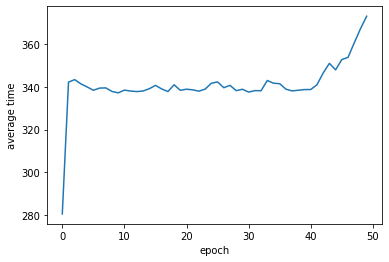

In [ ]:
plt.plot(AVG_TIME)
plt.ylabel('average time')
plt.xlabel('epoch')
plt.show()

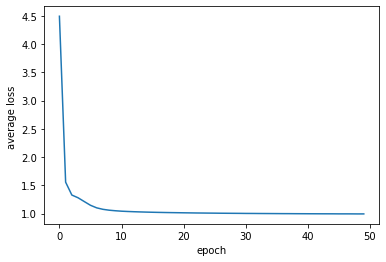

In [ ]:
plt.plot(AVG_LOSS_LIST)
plt.ylabel('average loss ')
plt.xlabel('epoch')
plt.show()